## Scraper Suno Analítica

Scraper para ler/coletar histórico de dados fundamentalistas (demonstração de resultados, balanço patrimonial e demonstrativo de fluxo de caixa) apresentados no site https://www.sunoresearch.com.br/acoes/, possibilitando uma análise fundamentalista automatizada.

**Atenção:** Futuramento poderá ser implementada a leitura de dados dos indicadores históricos.  
Infelizmente, muitos destes indicadores são calculados considerando a quantidade de ações, algo que a plataforma está calculando erroneamente (o cálculo na data de hoje: 18 de abril de 2020, é feito considerando somente a quantidade de ações do ticker consultado, e não sobre todas as ações existentes da empresa *ON + PN*, acarretando assim a apresentação incorretas de informações).


In [1]:
# import
import requests
import pandas as pd
from enum import Enum

Função e constantes para fazer leitura dos dados

In [2]:
# Constantes de pesquisa
class STATEMENT_TYPE(Enum):
    RESULTS_REPORT = 'GetStatementResultsReportByTicker'  # Demonstração de resultados
    BALANCE_SHEET  = 'GetStatementBalanceSheetByTicker'   # Balanço patrimonial
    CASH_FLOW      = 'GetStatementCashFlowByTicker'       # Fluxo de caixa

    
class PERIOD_TYPE(Enum):
    QUARTER        = 'q'  # resultados trimestrais
    YEAR           = 'y'  # resultados anuais

# Função - json
def get_statement_json(ticker, statement_type, period_type, period_count=999):
    base_url = 'https://api-analitica.sunoresearch.com.br/api/Statement/{}'.format(statement_type.value)
    params = {
        'ticker': ticker,
        'type': period_type.value,
        'period':period_count,
    }
    json_data = requests.get(base_url, params=params).json()
    return json_data

# Função - Dataframe
def get_statement_df(ticker, statement_type, period_type, period_count=999):
    json_data = get_statement_json(ticker, statement_type, period_type, period_count)
    data_df = pd.DataFrame.from_dict(json_data)
    return data_df

Coletando dados de exemplo

In [3]:
ticker = 'PETR4'
data_df = get_statement_df(ticker, STATEMENT_TYPE.RESULTS_REPORT, PERIOD_TYPE.QUARTER)

#### Analisando os dados

##### Colunas disponíveis (overview)
- colunas com nomes simples (C_4T2019, C_3T2019, C_2T2019): representam os valores financeiros sobre cada informação conforme coluna `descrição`
- colunas finalisadas com `AV` (C_4T2019_AV, C_3T2019_AV, C_2T2019_AV): representam valor percentual referente seu peso no balanço
- colunas finalizadas com `AH` (C_3T2019_AH, C_2T2019_AH, C_1T2019_AH): representam variação sobre o valor histórico anterior, sendo assim um comparativo

In [4]:
data_df.columns

Index(['level', 'sublevel', 'description', 'C_4T2019', 'C_4T2019_AV',
       'C_3T2019', 'C_3T2019_AV', 'C_3T2019_AH', 'C_2T2019', 'C_2T2019_AV',
       ...
       'C_2T2010_AH', 'C_1T2010', 'C_1T2010_AV', 'C_1T2010_AH', 'C_4T2009',
       'C_4T2009_AV', 'C_4T2009_AH', 'C_4T2008', 'C_4T2008_AV', 'C_4T2008_AH'],
      dtype='object', length=128)

##### Visualização dos valores

In [5]:
cleaned_df = data_df

# criando indices pelos níveis e pela descrição (ignorando colunas dos valores)
cleaned_df = cleaned_df.set_index([col for col in data_df.columns if 'C_' not in col])

# exemplo de dados
cleaned_df[cleaned_df.columns[:6]]

C_4T2019  C_4T2019_AV  \
level sublevel description                                                 
1     0        Receita Líquida                 7.262800e+10     1.000000   
      1        Custos                         -3.716300e+10    -0.511690   
2     0        Lucro Bruto                     3.546500e+10     0.488310   
      1        Despesas/Receitas Operacionais -2.181900e+10    -0.300421   
3     0        EBIT                            1.364600e+10     0.187889   
      1        Resultado Financeiro           -6.862000e+09    -0.094481   
      2        Impostos                        1.277000e+09     0.017583   
4     0        Lucro Líquido                   8.538000e+09     0.117558   
      1        Amortização/Depreciação        -1.494500e+10    -0.205775   
5     0        EBITDA                          2.859100e+10     0.393664   

                                                   C_3T2019  C_3T2019_AV  \
level sublevel description                                                 
1     0        Receita Líquida                 7.705100e+10     1.000000   
      1        Custos                         -4.704500e+10    -0.610570   
2     0        Lucro Bruto                     3.000600e+10     0.389430   
      1        Despesas/Receitas Operacionais -1.570300e+10    -0.203800   
3     0        EBIT                            1.430300e+10     0.185630   
      1        Resultado Financeiro           -1.087400e+10    -0.141127   
      2        Impostos                       -3.938000e+09    -0.051109   
4     0        Lucro Líquido                   8.840000e+09     0.114729   
      1        Amortização/Depreciação        -1.498500e+10    -0.194482   
5     0        EBITDA                          2.928800e+10     0.380112   

                                               C_3T2019_AH      C_2T2019  
level sublevel description                                                
1     0        Receita Líquida                   -0.057404  7.256700e+10  
      1        Custos                            -0.210054 -4.235700e+10  
2     0        Lucro Bruto                        0.181930  3.021000e+10  
      1        Despesas/Receitas Operacionais     0.389480  9.027000e+09  
3     0        EBIT                              -0.045934  3.923700e+10  
      1        Resultado Financeiro              -0.368953 -8.576000e+09  
      2        Impostos                          -1.324276 -1.161100e+10  
4     0        Lucro Líquido                     -0.034163  1.935200e+10  
      1        Amortização/Depreciação           -0.002669 -1.456800e+10  
5     0        EBITDA                            -0.023798  5.380500e+10

### Visualização gráficas (somente)

Gráfico de valores financeiros

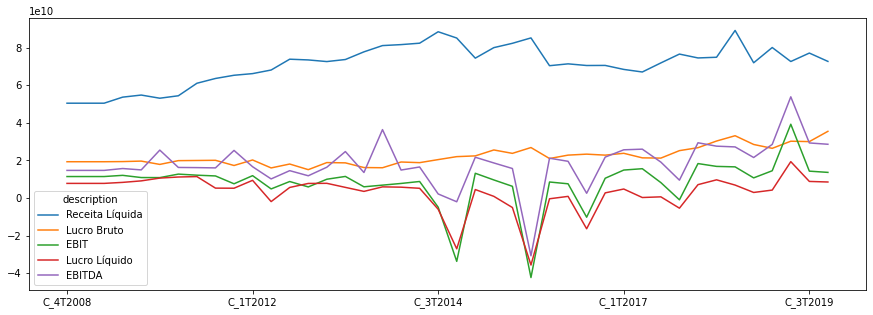

In [6]:
# Gráfico (níveis superiores)
graf_df = cleaned_df.reset_index().set_index('description')

# filtrando somente por subníveis mais alto
graf_df = graf_df[graf_df['sublevel'] == float(0)]

# remove controle de níveis
graf_df = graf_df.drop(['level', 'sublevel'], axis=1)

# filtrando somente por colunas com valores financeiros
graf_df = graf_df.drop([col for col in graf_df.columns if '_AH' in col], axis=1)
graf_df = graf_df.drop([col for col in graf_df.columns if '_AV' in col], axis=1)

# Apresenta gráfico
graf_df.T[::-1].plot(figsize=(15,5))

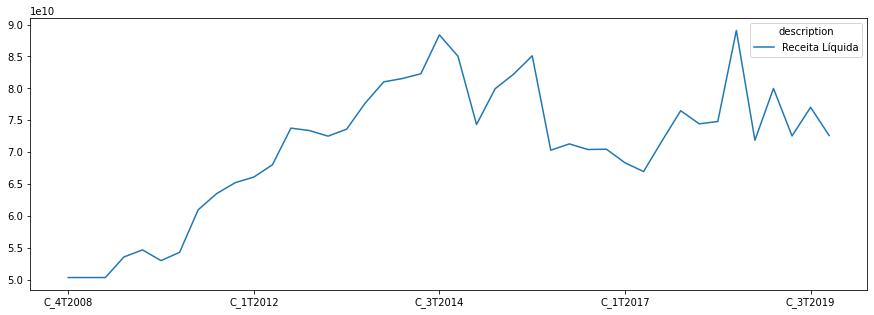

In [7]:
# filtrando somente por um indicador
graf_df = graf_df[graf_df.index == 'Receita Líquida']

# Apresenta gráfico
graf_df.T[::-1].plot(figsize=(15,5))

Gráfico dos percentuais de evolução (se fizer algum sentido)

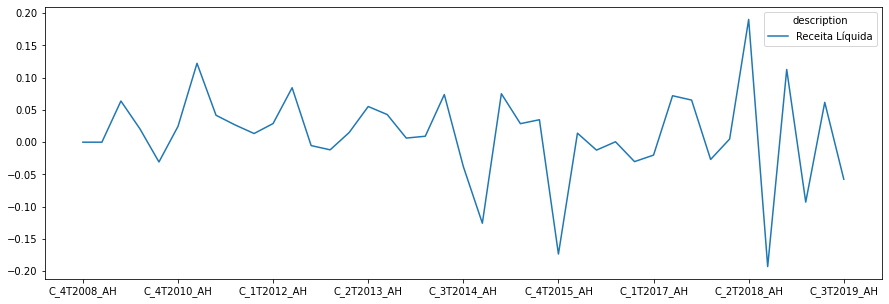

In [8]:
# Gráfico dos níveis superiores
graf_df = cleaned_df.reset_index().set_index('description')

# filtrando somente por subníveis mais alto
graf_df = graf_df[graf_df['sublevel'] == float(0)]

# remove controle de níveis
graf_df = graf_df.drop(['level', 'sublevel'], axis=1)

# filtrando somente por colunas pelos percentuais balanço contra balanço
graf_df = graf_df[[col for col in graf_df.columns if '_AH' in col]]

# filtrando somente por um indicador
graf_df = graf_df[graf_df.index == 'Receita Líquida']

# Apresenta gráfico
graf_df.T[::-1].plot(figsize=(15,5))

In [15]:
# Representação percentual
graf_df = cleaned_df

# filtrando somente por colunas pelos percentuais balanço contra balanço
graf_df = graf_df[[col for col in graf_df.columns if '_AV' in col]]

# pega último demonstrativo apresentado
graf_df = graf_df[graf_df.columns[:1]] * 100
graf_df.style.format('{:,.2f}%')